### Auto Labelling with EM

**Import required libraries**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

**Load and preprocess data**

In [2]:
mnist = pd.read_csv('mnist234.csv')
mnist.head()

,Unnamed: 0,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,16,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


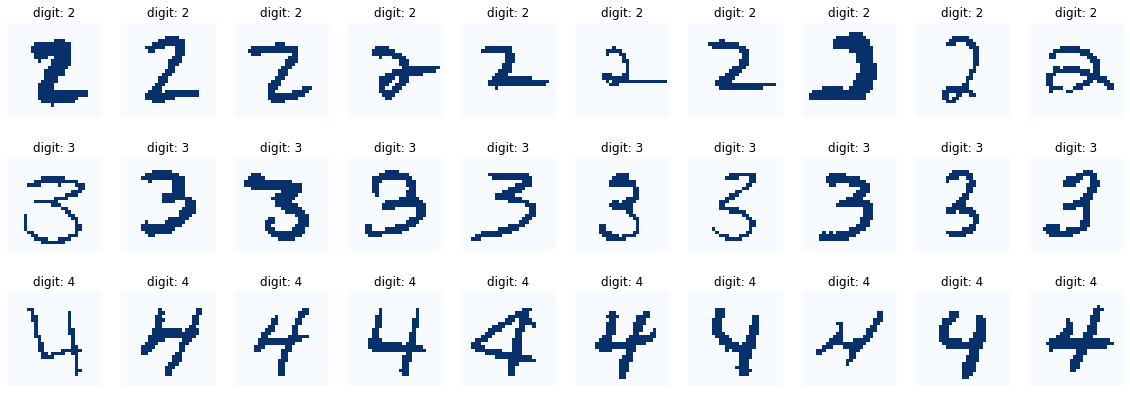

In [5]:
# Preprocess data

data = mnist.iloc[:,2:] # pixels/features
y  = mnist.iloc[:,1]  # true labels
MAX = np.max( np.array(data.iloc[:,:]))
data.iloc[:,:] = np.round(data.iloc[:,:]/MAX)   # scale b.w. 0 and 1 

# Preview Dataset
fig, axes = plt.subplots(3, 10, figsize=(20, 7))
for j in range(3):
    for i in range(200*j,200*j+10):
        axes[j, i %10].imshow(np.array(data.iloc[i,:]).reshape(28,28), cmap='Blues')
        axes[j, i %10].axis('off')
        axes[j, i %10].set_title(f"digit: {y[i]}")


**EM Algorithm Implementation for Bernoulli Mixture Model**

In [13]:
# EM Algorithm for Bernoulli Mixture Model (BMM)

start = time.time()

K = 3 # No of Bernoulli Distribution in Mixture 
D = data.shape[1] # No of pixels in each image 
N = len(data)  # Total number of images in dataset

# Init Step : Randomly initialize πj(0), Pkj(0) for k=0,1,..,D-1 and j=0,1,...,K-1
π_prev = np.array([ 1./K for j in range(K) ])
P_prev = np.array([ [np.random.randint(25,75)/100 for j in range(K)] for k in range(D)])
P_prev = (P_prev.T/np.sum(P_prev,axis=1)).T # Normalize to satisfy contraint on each pixel
γ_prev = np.array([ [0. for j in range(K)] for i in range(N) ])
Z = [np.random.choice(range(K)) for i in range(N)]  # randomly assign every point to exactly one of K classes

π_curr = π_prev.copy()
P_curr = P_prev.copy()
γ_curr = γ_prev.copy()

t = 0 
epsilon = 0.001

print("Begining EM Algorithm for BMM")

t=0

while t < 50 : 

    start = time.time()
    
    for i in range(N):
        # E-Step 
        point = data.iloc[i,:].values.reshape(-1,1)
        numerators = np.power(P_prev,point)*np.power(1-P_prev,1-point)
        numerators = np.prod(numerators,axis=0)
        tmp = np.multiply(π_prev,numerators)
        γ_curr[i,:]= tmp/np.sum(tmp)
        # End E-Step
    Z[:] = np.argmax(γ_curr,axis=1)
    end1 = time.time()
    #M-Step
    π_curr = np.sum(γ_curr,axis=0)/N
    denominators = np.sum(γ_curr,axis=0)
    P_curr[:,:] = (data.values.T@γ_curr)/denominators 
    # End M-Step

    errors = np.array( [np.linalg.norm(P_curr- P_prev),np.linalg.norm(π_curr - π_prev)])
    
    if np.array((errors < epsilon)).all() : 
        print("Finishing EM algorithm for BMM. Bye! ^_^ ")
        print("\n Errors : ",errors)
        break

    P_prev, π_prev = P_curr.copy(), π_curr.copy()
    end2 = time.time()
    print( "Iteration %d : "%t, "Errors : ", errors)
    t = t+1

Begining EM Algorithm for BMM
Iteration 0 :  Errors :  [13.44421638  0.28329093]
Iteration 1 :  Errors :  [2.59400586 0.15456626]
Iteration 2 :  Errors :  [1.40711178 0.05662496]
Iteration 3 :  Errors :  [0.52774061 0.02661527]
Iteration 4 :  Errors :  [0.39627436 0.01879423]
Iteration 5 :  Errors :  [0.31174142 0.01007234]
Iteration 6 :  Errors :  [0.17516305 0.01080868]
Iteration 7 :  Errors :  [0.20790524 0.00785008]
Iteration 8 :  Errors :  [0.27092019 0.00667152]
Iteration 9 :  Errors :  [0.30510093 0.00753913]
Iteration 10 :  Errors :  [0.33313372 0.01890431]
Iteration 11 :  Errors :  [0.46164176 0.02861044]
Iteration 12 :  Errors :  [0.15846296 0.0099658 ]
Iteration 13 :  Errors :  [0.11375902 0.00526738]
Iteration 14 :  Errors :  [0.10144192 0.00136203]
Iteration 15 :  Errors :  [0.10025507 0.00334059]
Iteration 16 :  Errors :  [0.1212804  0.00386101]
Iteration 17 :  Errors :  [0.24773576 0.01054567]
Iteration 18 :  Errors :  [0.126787   0.00629177]
Iteration 19 :  Errors :  [0

In [18]:
# Labelling predictions

Z = np.array(Z)
predictions = np.array([0 for i in range(N)])
for j in range(K):
    index = np.where(Z==j)[0]
    true = y[index]
    counter = {2:0,3:0,4:0}
    for t in true : 
        counter[t] += 1
    keys = list(counter.keys())
    values = list(counter.values())
    pred = keys[np.argmax(values)]
    pred
    predictions[index] = pred

error = np.sum(predictions != y)
print("No of images misclassified out of %d images : %d"%(len(Z),error))

acc = np.sum(predictions == y)/len(y)*100
print("Accuracy : %0.2f"%acc, "%")

No of images misclassified out of 600 images : 73
Accuracy : 87.83 %
